#  "Region Growing" and "Superpixels"


# Recap

This is the Lab on Region Growing and Superpixels for Classical Image Segmention in CE6003. You should complete the tasks in this lab as part of the Region Growing section of the lesson.

Please remember this lab must be completed before taking the quiz at the end of this lesson.


First, if we haven't already done so, we need to clone the various images and resources needed to run these labs into our workspace.

In [1]:
!git clone https://github.com/EmdaloTechnologies/CE6003.git

Cloning into 'CE6003'...
remote: Enumerating objects: 10, done.
remote: Counting objects: 100% (10/10), done.
remote: Compressing objects: 100% (7/7), done.
remote: Total 90 (delta 3), reused 8 (delta 3), pack-reused 80
Unpacking objects: 100% (90/90), done.


# Introduction

In this lab you will complete your third image segmentation project where you will use the watershed algorithm to segment a relatively complex image containing objects which are touching each other. 

You will also complete a short super-pixel based segmentation example.

Please work through these projects using the image processing techniques from the previous labs and then segment the example images, once using watershed and once using super-pixels.

At the end of the lab we'll review the work we've done and assess what types of images and projects these approaches are effective for.


# Goal

In this lab, you will: 
* learn about one introductary 'region growing' image segmentation techique - 'watershed';
* revise deblurring, thresholding, dilation, opening, and the distance transformation;
* use cv2.watershed() to segment an image;
* gain an insight into superpixels.  This is a very important topic in neural network based image processing!
* segment the tomatoes image into superpixels
* use the SLIC algorithm

# Background

Image segmentation is the process of partitioning a digital image into multiple segments to make the image easier to analyze.  Often we are looking to locate objects and boundaries in the original image.  Another way of looking at it is image segmentation's goal is to assign a label to every pixel in an image such that pixels with the same label share certain characteristics.  Like many elements of computer vision, I find an example is often more useful than precise text.

For example, these images show a typical road scene on the left and a segmented version of the image on the right.

<p float="center">
  <img src="https://github.com/EmdaloTechnologies/CE6003/blob/master/images/lab2/bg-road.png?raw=1" width="450" />
</p>


# Region Growing - 'Watershed'

The simplest image segmentation techniques, like the thresholding we used in Lab 1, start to show their limitations pretty quickly - requirements like segmenting beyond two objects, touching objects or overlapping objects, etc quickly lead us to techniques such as Watershed,

'Watershed' is a (mostly) unsuperised algorithm used to isolate portions of an image from each other - in
effect image segmentation.  Its worth noting, however, that - similar to most classical image processing 'watershed' works by identifying elements of the image such as color intensity. i.e. 'watershed' has no semantic understanding of the contents of the image.

The watershed algorithm is useful for segmentation and is relatively strong at detecting touching or overlapping objects in images such as the image of tomatoes below.

<img src="https://github.com/EmdaloTechnologies/CE6003/blob/master/images/lab2/tomatoes.png?raw=1" alt="Tomatoes" style="width: 200px;"/>

So to summarise, algorithms like 'watershed' have applications where simpler methods such as thresholding and contour detection fail. 



# Theory behind Watershed

After converting an image to greyscale, we can imagine that greyscale image as being a topographic surface (a height map) where high intensity denotes 'hills' and low intensity denotes 'valleys'.  Conceptually, we start by assigning every isolated 'valley' with different colour liquid.  These correspond to our labels.  As the liquids rise, the various liquids from different valleys start to merge.  We want to avoid these mergers.  To avoid mergers, we build barriers at the merger locations.  We continue to fill the liquids until all the hills are under liquid.  

We can visually grasp the concept using the simple square image on the left and its topographic representation on the right.  We can imagine filling the topographic representation of our square with two liquids, one inside the square and one outside the square.  As each liquid meets each other we create a 'watershed', and we can imagine this representing the square.

Original                 | Topography            
:-----------------------:|:--------------------------------:
<img src="https://github.com/EmdaloTechnologies/CE6003/blob/master/images/lab2/simple_square.png?raw=1" alt="Simple Square" style="width: 200px;"/> | <img src="https://github.com/EmdaloTechnologies/CE6003/blob/master/images/lab2/simple_square_topography.png?raw=1" alt="Simple Square Topography" style="width: 200px;"/>


Similarly, we can imagine the tomatoes below on the left, being transformed into a 3d shape being filled with a liquid until the individual tomatoes emerge.

Original                 | Topography            
:-----------------------:|:--------------------------------:
<img src="https://github.com/EmdaloTechnologies/CE6003/blob/master/images/lab2/tomatoes.png?raw=1" alt="Tomatoes" style="width: 200px;"/> | <img src="https://github.com/EmdaloTechnologies/CE6003/blob/master/images/lab2/tomatoes_topography.png?raw=1" alt="Tomatoes Topography" style="width: 200px;"/>

## Watershed in Practice

The watershed algorithm tends to give us over-segmented results due to noise etc in the image.  So its typical to simplify the image before sending it to the Watershed algorithm, and as you'll see below, there's almost invariably a denoising step.


## OpenCV Watershed

A big improvement of the watershed transformation consists of flooding the topographic surface from a previously defined set of markers. This effectively automates the process of starting the watershed algorithm off by giving
it hints where to start filling from.

The OpenCV watershed algorithm has two parameters, the image being worked on and a second image.
This second image contains 'markers'. These markers must be 'user-defined'.  

We won't manually define them (e.g. using point-and-click; instead we'll heuristically define them instead using thresholding and/or morphological operations.

Then we'll apply the watershed algorithm to our image using that marker.

# Our Technique
In this technique, we will see how to use the Distance Transformation along with the watershed algorithm to segment some objects.

Let''s remind ourselves of our image of tomatoes.  As you can see, this is an image where several of the objects are touching or overlapping.  We could tune the thresholding algorithm we used in Lab 1 or the clustering algorithm we used in Lab 2 to detect multiple objects and segment the image into those objects but its likely that they will be unable to distinguish between the two red tomatoes on the left hand side of the image as we look at it.

<img src="https://github.com/EmdaloTechnologies/CE6003/blob/master/images/lab2/tomatoes.png?raw=1" alt="Tomatoes" style="width: 300px;"/>

Instead, we'll start by preparing the image such that the OpenCV 'waterfall' can operate on this image.  

Our overall goal here is to construct a 'marker' image for OpenCV's 'waterfall' routine.  The marker area is, effectively, an initial area of the image which guides the 'waterfall' algorithm to help with over-segmenting.

Initially we will create an object mask, a background mask and then subtract one from the other to create a mask of the 'unknown' part of the image.

 So, in this example, we will 'semi-automate' the process of providing marker to watershed algo
 1. decide what is clearly background
 2. decide what is clearly foreground
 3. create a region that's neither clearly background nor foreground
 4. set up 'marker' around this area
 5. hand that off to watermark

We start by converting the tomatoes image to greyscale, applying a little Gaussian blur and then using a relatively high threshold to to simplify the image.


In [0]:
# Similar to previous labs, we're going to use OpenCV, NumPY and MatPlotLib
# so import them here
import cv2
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# Load an image
img = cv2.imread("/content/CE6003/images/lab2/tomatoes.png")

In [0]:
# YOUR CODE GOES HERE
# The degree of blurring is strongly coupled with the performance of the watershed.  
# It can be quite interesting to experiment with adjusting the amount of blurring.
# Exercise: Try using cv2.GaussianBlur() until your image is satisfactory.
# You have a reference image below to help you if you want it.
# Store the output from cv2.GaussianBlur() in a variable called blur
#img2 = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
blur = cv2.GaussianBlur(img, (43, 43), 0)
#plt.imshow(blur)#, cmap='gray')
# END YOUR CODE HERE

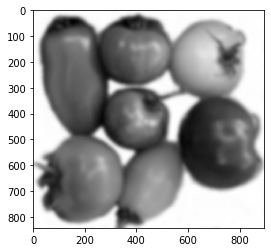

In [345]:
# Convert to grayscale so we can threshold it
gray = cv2.cvtColor(blur, cv2.COLOR_BGR2GRAY)

plt.imshow(gray, cmap='gray')

So, after these operations, you should be starting to see the tomatoes emerge from the background.  

Your blurred grayscale image should be similar to the image here.

<img src="https://github.com/EmdaloTechnologies/CE6003/blob/master/images/lab2/tomatoes_grayscale.png?raw=1" alt="Segmented Starfish" align="left" style="width: 300px;"/>




In [0]:
# YOUR CODE GOES HERE
# Experiment: So, create a matrix thresh which is thresholded by OpenCV's threshold() operation.
# HINT: I did not using OTSU here as I got better results from 
# weighting the threshold high. You can experiment here with thresholding to 
# improve on the final segmentation.
#
# Use the method cv2.threshold() which returns two values. The second value is the
# value you are interested in, you can ignore the first for now...
# https://techtutorialsx.com/2019/04/13/python-opencv-converting-image-to-black-and-white/
ret,thresh = cv2.threshold(gray,190,255,cv2.THRESH_BINARY_INV)
# Store the value in a variable called thres
# END YOUR CODE GOES HERE


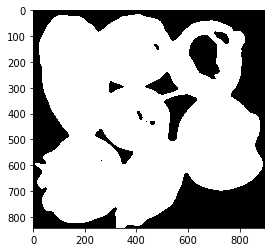

In [352]:
#thresh = cv2.cvtColor(thresh, cv2.COLOR_BGR2GRAY)

plt.imshow(thresh, cmap='gray')

#plt.imshow(thresh)

Now, you should have a matrix (or image if you prefer) which is similar to this image.

After these operations, we're starting to see the tomatoes emerge from the background.  Note in this example that, its a little more complex than the starfish example, in that the objects of interest are touching and/or overlapping.

<img src="https://github.com/EmdaloTechnologies/CE6003/blob/master/images/lab2/tomatoes_thresh.png?raw=1" alt="Tomatoes B&W" align="left" style="width: 300px;"/>


# Prepare the marker image

Now you need to prepare the foreground, background, and unknown regions of the image to create a marker for OpenCV's watershed().

At this stage, we can start preparing the foreground, background, and 'unknown' regions of the image.  For this image, I used a closing morphological operation followed by a dilation to generate the background image and I used a distance transform to generate the foreground image.  Finally, I subtracted those two images from each other to generate the unknown area of the image.

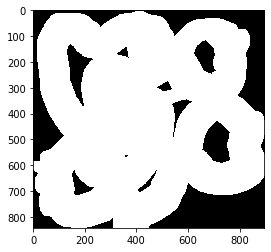

In [353]:
#  Close the image a little to fill in a few small holes in it
closingKernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (3,3))

# Create a matrix closed that is generated from thresh by a closing
# operation using the kernel above.
closed = cv2.morphologyEx(thresh, cv2.MORPH_CLOSE, closingKernel)

# Use just enough dilate to get some clearly identifiable background
dilationKernel = np.ones((4,4), np.uint8)

# create a matrix 'bg' from OpenCV's dilate() function
# using the dilation kernel above
bg = cv2.dilate(closed, dilationKernel, iterations=9)

# Now use a distance transform to extract is clearly foreground

# Create a matrix 'dist_transform' using OpenCV's distanceTransform
# method on the 'closed' matrix.
dist_transform = cv2.distanceTransform(closed, cv2.DIST_L2, 5)

# Threshold the distance transformation
ret, fg = cv2.threshold(dist_transform,0.7*dist_transform.max(), 255, 0)

# Now find the unknown region by subtracting one from the other
fg = np.uint8(fg)
unknown = cv2.subtract(bg, fg)

plt.imshow(unknown, cmap='gray')

At this point your unknown region should be substantially similar to the image on the right here.  I've also included a reference background image and foreground (or object) image in case you lose your way a little.

Background                 | Foreground         | Unknown            
:-----------------------:|:--------------------------------:|--------------:
<img src="https://github.com/EmdaloTechnologies/CE6003/blob/master/images/lab2/tomatoes_bg.png?raw=1" alt="Tomatoes BG" style="width: 200px;"/> | <img src="https://github.com/EmdaloTechnologies/CE6003/blob/master/images/lab2/tomatoes_fg.png?raw=1" alt="Tomatoes FG" style="width: 200px;"/> | <img src="https://github.com/EmdaloTechnologies/CE6003/blob/master/images/lab2/tomatoes_unknown.png?raw=1" alt="Tomatoes Unknown" style="width: 200px;"/>

Now, we're ready to do a little data manipulation before calling OpenCV's watershed. 

Right now what we have in marker is a set of pixel values, with 0 representing the background and 255 representing the unknown region and what OpenCV's watershed expects to see in marker is the unknown region set to 0. So, you need to run the following code to prepare for watershed.


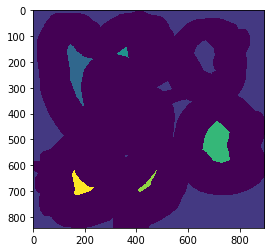

In [354]:
# Marker labelling
ret, marker = cv2.connectedComponents(fg)

# Add one to all labels so that bg is not  0, but 1
marker = marker+1

# Now, mark the region of unknown with 0
marker[unknown==255] = 0;

plt.imshow(marker)


At this stage you should be seeing an image substantively similar to one shown here.

<img src="https://github.com/EmdaloTechnologies/CE6003/blob/master/images/lab2/tomatoes_marker.png?raw=1" alt="Tomatoes Marker" align="left" style="width: 300px;"/>



Now we can run watershed over our image. Then we'll colour the segmentation boundaries the watershed found in green and save it.

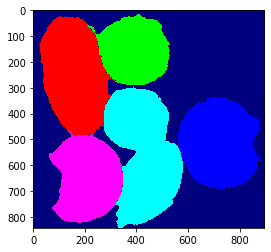

In [355]:
# Now marker is ready.  It is time for last step
cv2.watershed(img, marker)

# Create a new empty image with the same shape
# as the original image.
h, w, num_c = img.shape
seg = np.zeros((h, w, num_c), np.uint8)

# Watershed has replaced the pixel
# values in marker with integers representing
# the segments it has found in the original
# image.
# Color in these segments
# 
maxMarker = np.max(marker)
minMarker = np.min(marker)

colorMap =  [ \
             [0,0,0], \
             [255,255,255], \
             [127,0,0], \
             [0,0,255], \
             [0,255,0], \
             [255,0,0], \
             [255,255,0], \
             [255,0,255], \
             [0,255,255] \
            ]

for region in range(minMarker, maxMarker+1):
    seg[marker==region] = colorMap[region+1]
    
plt.imshow(cv2.cvtColor(seg, cv2.COLOR_BGR2RGB))


Now your image should be similar to the one I've shown here.

<img src="https://github.com/EmdaloTechnologies/CE6003/blob/master/images/lab2/tomatoes_segmented.png?raw=1" alt="Tomatoes Segmented" align="left" style="width: 300px;"/>


There are a few items I want to highlight at this stage - most notably we've missed the yellow tomato on top t the right and two of our tomatoes have 'merged'.  

We can continue to tweak to improve the segmentation for this image, but its probably more productive to just note, for now, that - with classical algorithms - we can often end up hand-crafting our features.



# SLIC

We'll be talking about super-pixels at a later stage in this module. We're going to do a short lab with super-pixels here to introduce them.

You'll find a more detailed discussion of super-pixels and the SLIC algorithm in the accompanying lesson for this lab.

In summary, an isolated pixel does conveys extremely little information about the image it resided within. There would appear to be good benefits from gathering pixels together to gain some semantic information - i.e. to create a 'thing' which is capable of carrying some 'meaning'.

If we call out the work of Dr. Xiaofeng Ren's work here super-pizels would ideally contain perceptual meaningfulness - for instance colour, texture, etc (and ideally semantic value). This property leads towards their use in neural networks.

As you will see, super-pixels also offer computational efficiency - the reduce the complexity of images from hundreds of thoushands of pixels to hundreds of pixels.

Super-pixelation tends to lead to the detection of the boundaries we desire while having a side-effect of over-segmenting and introducing boundaries we don't want.  Pleae keep this insight as you work through this lab and retain it as you work through later lessons.  


For this algorithm, you'll need to import the 'segmentation' package

In [0]:
from skimage import segmentation, color
from skimage.io import imread
from skimage.io import imsave

Now, load your image.  We''re going to use the relatively complex tomatoes image again.  However, this time, please don''t blur or grayscale the image.

In [0]:
# Load an image
img = imread("/content/CE6003/images/lab2/tomatoes.png")

Run the SLIC super-pixel algorithm over the image, varying the compactness and the numsegments until the image you produce resembles the image below.

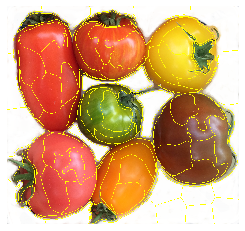

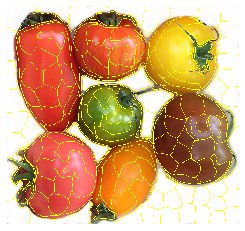

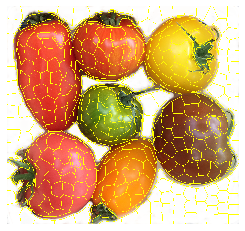

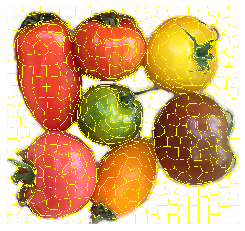

In [358]:
# YOUR CODE HERE
# Experiment: Vary numSegments to find a reasonable value for it for this image
# Important Note: You are manually selecting features and feature properties 
# (e.g. size of super-pixels) here
# https://www.pyimagesearch.com/2014/07/28/a-slic-superpixel-tutorial-using-python/ 
image = img
 
# loop over the number of segments
for numSegments in (100, 200, 400, 500):
	# apply SLIC and extract (approximately) the supplied number
	# of segments
	segments = segmentation.slic(image, n_segments = numSegments, sigma = 5)
 
	# show the output of SLIC
	fig = plt.figure("Superpixels -- %d segments" % (numSegments))
	ax = fig.add_subplot(1, 1, 1)
	ax.imshow(segmentation.mark_boundaries(image, segments))
	plt.axis("off")
 
# show the plots
plt.show()

# Exercise: set the variable numSegments to a suitable value
# END YOUR CODE HERE

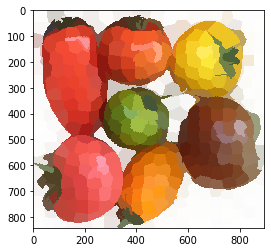

In [361]:
compactFactor = 20
numSegments = 400
img_segments = segmentation.slic(img, compactness=compactFactor, n_segments=numSegments)
superpixels = color.label2rgb(img_segments, img, kind='avg')

plt.imshow(superpixels)

Now your image should be similar to the one shown here.

<img src="https://github.com/EmdaloTechnologies/CE6003/blob/master/images/lab2/tomatoes_slic.png?raw=1" alt="Tomatoes Superpixel version" align="left" style="width: 300px;"/>



To complete the assignment, you should run the watershed algorithm over the image you created in the last step.

Your aim is to produce an image similar to the one below.

<img src="https://github.com/EmdaloTechnologies/CE6003/blob/master/images/lab2/tomatoes_slic_watershed_seg.png?raw=1" alt="Tomatoes Superpixel Watershed Segmented" align="left" style="width: 300px;"/>


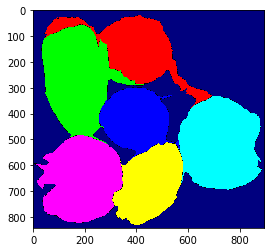

In [335]:
#Create Superpixel 
compactFactor = 20
numSegments = 400
img_segments = segmentation.slic(img, compactness=compactFactor, n_segments=numSegments)
superpixels = color.label2rgb(img_segments, img, kind='avg')
#Plt.imshow(cv2.cvtColor(superpixels, cv2.COLOR_BGR2RGB))

#Gray scale
#blur = cv2.GaussianBlur(superpixels, (1, 1), 0)
gray = cv2.cvtColor(superpixels, cv2.COLOR_BGR2GRAY)
#plt.imshow(gray, cmap='gray')

#Binary Threshold
ret,thresh = cv2.threshold(gray,210,255,cv2.THRESH_BINARY_INV)
#ret,thresh = cv2.threshold(superpixels,190,255,cv2.THRESH_BINARY_INV)

#  Close the image a little to fill in a few small holes in it
closingKernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (3,3))

# Create a matrix closed that is generated from thresh by a closing
# operation using the kernel above.
closed = cv2.morphologyEx(thresh, cv2.MORPH_CLOSE, closingKernel)

# Use just enough dilate to get some clearly identifiable background
dilationKernel = np.ones((3,3), np.uint8)

# create a matrix 'bg' from OpenCV's dilate() function
# using the dilation kernel above
bg = cv2.dilate(closed, dilationKernel, iterations=10)

# Now use a distance transform to extract is clearly foreground

# Create a matrix 'dist_transform' using OpenCV's distanceTransform
# method on the 'closed' matrix.
dist_transform = cv2.distanceTransform(closed, cv2.DIST_L2, 5)

# Threshold the distance transformation
ret, fg = cv2.threshold(dist_transform,0.7*dist_transform.max(), 255, 0)

# Now find the unknown region by subtracting one from the other
fg = np.uint8(fg)
unknown = cv2.subtract(bg, fg)
#plt.imshow(unknown, cmap='gray')

# Marker labelling
ret, marker = cv2.connectedComponents(fg)

# Add one to all labels so that bg is not  0, but 1
marker = marker+1

# Now, mark the region of unknown with 0
marker[unknown==255] = 0;
#plt.imshow(marker)
# Now marker is ready.  It is time for last step
cv2.watershed(superpixels, marker)

# Create a new empty image with the same shape
# as the original image.
h, w, num_c = img.shape
seg = np.zeros((h, w, num_c), np.uint8)

# Watershed has replaced the pixel
# values in marker with integers representing
# the segments it has found in the original
# image.
# Color in these segments
# 
maxMarker = np.max(marker)
minMarker = np.min(marker)

colorMap =  [ \
             [0,0,0], \
             [255,255,255], \
             [127,0,0], \
             [0,0,255], \
             [0,255,0], \
             [255,0,0], \
             [255,255,0], \
             [255,0,255], \
             [0,255,255] \
            ]

for region in range(minMarker, maxMarker+1):
    seg[marker==region] = colorMap[region+1]
    
plt.imshow(cv2.cvtColor(seg, cv2.COLOR_BGR2RGB))

# Conclusion

So, that completes the third of the four labs in this lesson.

You've learned how to use erosion and dilation
You've learned how to use the watershed algorithm to segment an image with touching or overlapping regions.
You've been introduced to super-pixels and the SLIC algorithm
You've gained an insight that classical techniques involve manually tuning features like super-pixel size for individual images or classes of images and you should be asking yourself "surely, there's a better way?"
